In [1]:
import argparse

from utils.GraphAutoencoder_train_utils import *
from utils.utils import *

/home/icb/alejandro.tejada/miniconda3/envs/graph_cell/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = 'config/net_config/experiment01.yaml'

with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# CREATE DATALOADERS
dataloader_dict = dict(
    data_path=config['data']['data_path'],
    entities_path=config['data']['entities_path'],
    drugs_path=config['data']['drugs_path'],
    triples_path=config['data']['triples_path'],
    batch_size=config['training']['batch_size'],
    change_drugs=config['data']['change_drugs'],
    perturbation=config['data']['perturbation'],
    condition_key=config['data']['condition_key'],
    perturbation_key=config['data']['condition_key'],
    split_key='split',
    dose_key=config['data']['dose_key'],
    cell_type_key=config['data']['cell_type_key'],
    dataloader_splits=False,
)

datasets = prepare_data(dataloader_dict)

train_dataloader = DataLoader(datasets["training"],
                              batch_size=1,
                              num_workers=4,
                              pin_memory=True
                              )

# DEVICE AND MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define device

/mnt/home/icb/alejandro.tejada/knowldege_graph-/data_handling/GCN_dataset.py:398: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prunned_data.obs['drug_official'] = df
/mnt/home/icb/alejandro.tejada/knowldege_graph-/data_handling/GCN_dataset.py:310: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  self.drugs = torch.Tensor(drugs)


In [3]:
model = GraphAutoencoder(
        n_nodes=int(next(iter(train_dataloader))[0].num_nodes),
        num_drugs=datasets['training'].drugs.shape[1],
        num_cell_types=len(datasets['training'].covars_dict),
        adversarial=False,
        device=device,
        hparams=config_path,
        seed=0)
print("Model set")

GNN_network(
  (GNN): Sequential(
    (0): GCNConv(3, 3)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.1, inplace=False)
    (3): GCNConv(3, 2)
    (4): LeakyReLU(negative_slope=0.3)
    (5): Dropout(p=0.1, inplace=False)
    (6): GCNConv(2, 1)
    (7): LeakyReLU(negative_slope=0.3)
    (8): Dropout(p=0.1, inplace=False)
  )
)
5820 1024
Encoder Architecture:
	First Layer in, out: 5820 1024
	Hidden Layer 0 in/out: 1024 256
	Mean/Var Layer in/out: 256 64
Decoder Architecture:
	First Layer in, out 64 1024
	Output Layer in/out:  1024 5820 

GNN_network(
  (GNN): Sequential(
    (0): GCNConv(1, 1)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.1, inplace=False)
    (3): GCNConv(1, 2)
    (4): LeakyReLU(negative_slope=0.3)
    (5): Dropout(p=0.1, inplace=False)
  )
)
Model set


In [ ]:
model_trained = train_routine(model=model,
                              config=config,
                              datasets=datasets,
                              return_model=True)

In [18]:
model_name = '../trained_models/cuda_error/model_seed=18_epoch=500.pt'
state, args, history = torch.load(model_name, map_location=torch.device('cuda'))
args['dataset_path'] = '../GSM_new_allgenes.h5ad'

# load the dataset and model pre-trained weights

In [19]:
model.load_state_dict(state)

<All keys matched successfully>

In [20]:
train_dataloader = DataLoader(datasets["training"],
                              batch_size=12,
                              num_workers=4,
                              pin_memory=True
                              )

embedding = torch.empty(size=[0, 64]).to(device)
for graph, drug, cov in train_dataloader:
    x = graph.x.to(device)
    edge_index = graph.edge_index.to(device)
    batch = graph.batch.to(device)
    latent_basal = model.encode_graph(x, edge_index, batch)
    embedding = torch.cat([embedding, latent_basal], 0)
    
print(embedding.shape)

torch.Size([9303, 64])


In [21]:
import umap
import umap.plot

mapper = umap.UMAP().fit(embedding.detach().cpu())

<AxesSubplot:>

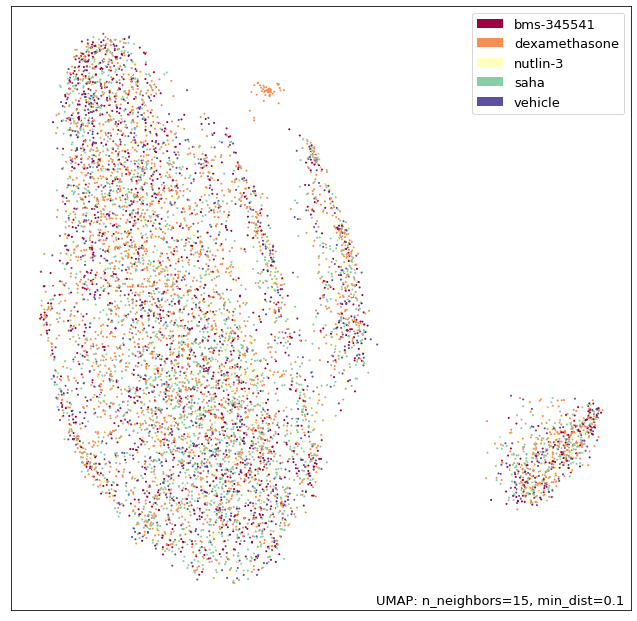

In [22]:
umap.plot.points(mapper, labels=datasets["training"].condition)

In [23]:
from compert.plotting import ComPertHistory

#history = model_trained.history

pretty_history = ComPertHistory(history)

In [24]:
history.keys()

dict_keys(['epoch', 'stats_epoch', 'loss_reconstruction', 'loss_adv_drugs', 'loss_adv_cell_types', 'penalty_adv_drugs', 'penalty_adv_cell_types', 'elapsed_time_min', 'training', 'test', 'ood', 'perturbation disentanglement', 'optimal for perturbations', 'covariate disentanglement', 'optimal for covariates'])

In [25]:
pretty_history.print_time()

Computation time: 138 min


In [26]:
pretty_history.losses

,epoch,loss_reconstruction,loss_adv_drugs,loss_adv_cell_types,penalty_adv_drugs,penalty_adv_cell_types
0,0,2.916789,0.0,0.0,0.0,0.0
1,1,2.914695,0.0,0.0,0.0,0.0
2,2,2.910866,0.0,0.0,0.0,0.0
3,3,2.913551,0.0,0.0,0.0,0.0
4,4,2.911036,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
496,496,-0.309406,0.0,0.0,0.0,0.0
497,497,-0.168545,0.0,0.0,0.0,0.0
498,498,-0.233017,0.0,0.0,0.0,0.0
499,499,-0.226363,0.0,0.0,0.0,0.0


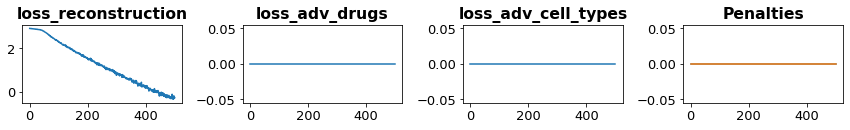

In [27]:
pretty_history.plot_losses()

In [ ]:
pretty_history.plot_metrics(epoch_min=0)

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
pytorch_total_params

12474123

In [7]:
from compert.api import ComPertAPI

compert_api = ComPertAPI(datasets, model)

In [16]:
compert_api.num_measured_points['training']

{'A549_BMS_0.001': 291,
 'A549_BMS_0.005': 386,
 'A549_BMS_0.01': 281,
 'A549_BMS_0.05': 192,
 'A549_BMS_0.1': 130,
 'A549_BMS_1.0': 74,
 'A549_Dex_0.001': 286,
 'A549_Dex_0.005': 303,
 'A549_Dex_0.01': 551,
 'A549_Dex_0.05': 539,
 'A549_Dex_0.1': 548,
 'A549_Dex_1.0': 590,
 'A549_Nutlin_0.001': 214,
 'A549_Nutlin_0.005': 199,
 'A549_Nutlin_0.01': 339,
 'A549_Nutlin_0.05': 381,
 'A549_Nutlin_0.1': 514,
 'A549_Nutlin_1.0': 45,
 'A549_SAHA_0.001': 395,
 'A549_SAHA_0.005': 430,
 'A549_SAHA_0.01': 440,
 'A549_SAHA_0.05': 332,
 'A549_SAHA_0.1': 358,
 'A549_SAHA_1.0': 335,
 'A549_Vehicle_1.0': 1150}

In [22]:
import json

with open('omnipath_triples/official_drug_names/GSM_new_allgenes.json') as json_file:
    data = json.load(json_file)

In [23]:
data

{'Nutlin': 'nutlin-3',
 'Dex': 'dexamethasone',
 'Vehicle': 'vehicle',
 'BMS': 'bms-345541',
 'SAHA': 'saha'}

In [26]:
datasets['training'].dict_in['drugs_official']

{'Nutlin': 'nutlin-3',
 'Dex': 'dexamethasone',
 'Vehicle': 'vehicle',
 'BMS': 'bms-345541',
 'SAHA': 'saha'}

In [25]:
self.comb_emb

AnnData object with n_obs × n_vars = 25 × 64
    obs: 'cov_pert', 'batch'

In [10]:
for cov_pert in self.seen_covars_perts['training']:
    print(cov_pert)

A549_BMS_0.001
A549_BMS_0.005
A549_BMS_0.01
A549_BMS_0.05
A549_BMS_0.1
A549_BMS_1.0
A549_Dex_0.001
A549_Dex_0.005
A549_Dex_0.01
A549_Dex_0.05
A549_Dex_0.1
A549_Dex_1.0
A549_Nutlin_0.001
A549_Nutlin_0.005
A549_Nutlin_0.01
A549_Nutlin_0.05
A549_Nutlin_0.1
A549_Nutlin_1.0
A549_SAHA_0.001
A549_SAHA_0.005
A549_SAHA_0.01
A549_SAHA_0.05
A549_SAHA_0.1
A549_SAHA_1.0
A549_Vehicle_1.0


In [17]:
compert_api.compute_comb_emb(thrh=0)
compert_api.compute_uncertainty(
                    cov='A549', 
                    pert='nutlin-3', 
                    dose='1.0'
                )

Cond_emb:  (1, 32)
self.comb_emb.X:  (25, 32)


(0.0, 0.0, 'A549_Nutlin_1.0', 'A549_Nutlin_1.0')

In [ ]:
datasets['training'].perts_dict

In [12]:
perts_anndata = compert_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 64
    obs: 'condition'

In [13]:
perts_anndata.obs.condition

0       bms-345541
1          vehicle
2         nutlin-3
3    dexamethasone
4             saha
Name: condition, dtype: object

In [8]:
from compert.plotting import CompertVisuals

compert_plots = CompertVisuals(compert_api, fileprefix=None)

In [ ]:
compert_plots.plot_latent_embeddings(compert_api.emb_perts, kind='perturbations', show_text=True)

In [16]:
compert_api.perturbation_key

'condition'

In [28]:
compert_api.dose_key

'dose'

In [10]:
latent_response[100:110]

,condition,dose,response
0,vehicle,0.000000,0.000000
1,vehicle,0.010101,0.479611
2,vehicle,0.020202,0.479676
3,vehicle,0.030303,0.479742
4,vehicle,0.040404,0.479803
5,vehicle,0.050505,0.479827
6,vehicle,0.060606,0.479851
7,vehicle,0.070707,0.479875
8,vehicle,0.080808,0.479900
9,vehicle,0.090909,0.479924


In [14]:
compert_api.perturbation_key

'condition'

DF_PLT:      condition      dose  response
0        saha  0.000000  0.000000
1        saha  0.010101  0.463393
2        saha  0.020202  0.463356
3        saha  0.030303  0.463335
4        saha  0.040404  0.463314
..        ...       ...       ...
495   vehicle  0.959596  0.470600
496   vehicle  0.969697  0.470525
497   vehicle  0.979798  0.470451
498   vehicle  0.989899  0.470376
499   vehicle  1.000000  0.470302

[500 rows x 3 columns]
Cont: dose
Resp:  response
Pert:  condition
Cold:  {'saha': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'nutlin-3': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), 'dexamethasone': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), 'bms-345541': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), 'vehicle': (1.0, 0.4980392156862745, 0.0)}
True


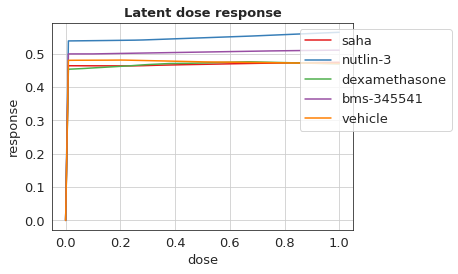

In [9]:
latent_response = compert_api.latent_dose_response(perturbations=None)
compert_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=compert_api.perturbation_key,
    title_name='Latent dose response')

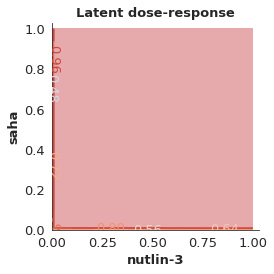

In [11]:
perturbations_pair = ['nutlin-3', 'saha']
latent_dose_2D = compert_api.latent_dose_response2D(perturbations_pair, n_points=100)
compert_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')

In [12]:
# %%time
df_reference = compert_api.get_response_reference(datasets)        


In [13]:
# %%time
reconstructed_response = compert_api.get_response(datasets)

TypeError: predict() missing 2 required positional arguments: 'drugs' and 'cell_types'